In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tfl
from sklearn.cluster import KMeans
from itertools import combinations

import hsilib as hl
hl = reload(hl)

In [3]:
import spectral.io.envi as envi
hsi_path = r'C:\Users\konst\jupyter_notebook\HSI\data envil\moffet\\'
moffett_hsi = envi.open(hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img.hdr',
                        hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img')

HSI = np.array(np.rot90(moffett_hsi.open_memmap(writble = True)))
height, width, bands = HSI.shape

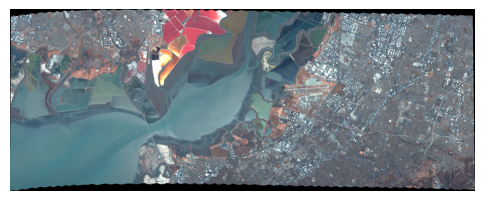

In [4]:
color_image = hl.HSI_to_RGB(HSI, (37, 18, 11))
hl.show(color_image)

In [5]:
norm_hsi = np.zeros(shape = HSI.shape, dtype = float)
mod_hsi = np.linalg.norm(HSI, axis = 2)
for i in range(height):
    for j in range(width):
        norm_hsi[i, j] = HSI[i, j] / mod_hsi[i, j]

In [6]:
main_diag_pix = np.ones(shape = bands) 
main_diag_pix = main_diag_pix / np.linalg.norm(main_diag_pix)

In [7]:
n_clust = 8
n_start_low_pix = int(height * width * 0.01) #24

In [8]:
angles_from_main_pix = np.zeros(shape = (height, width), dtype = float)
for i in range(height):
    for j in range(width):
        angles_from_main_pix[i, j] = np.dot(main_diag_pix, norm_hsi[i, j])

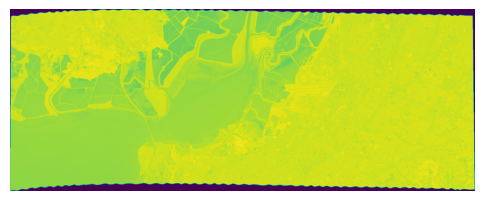

In [9]:
hl.show(angles_from_main_pix)

In [10]:
flatten_angles = np.reshape(angles_from_main_pix, (height * width))
arg_angles = np.arange(0, height * width, dtype = int)

bool_mask = np.reshape(np.any(HSI != -50, axis = 2), (height * width))

clear_flatten_angles = flatten_angles[bool_mask]
clear_arg_angles = arg_angles[bool_mask]

In [11]:
def too_index(index, width):
    w_i = index % width
    h_i = (index - w_i) // width
    return np.stack((h_i, w_i), axis = -1)

In [12]:
sort_pix_arg = clear_arg_angles[np.argsort(clear_flatten_angles)]
low_corr_pix_arg = too_index(sort_pix_arg, width)

In [13]:
low_corr_pix_arg

array([[  57, 1188],
       [  58, 1188],
       [  56, 1188],
       ...,
       [ 328, 1901],
       [ 180,  177],
       [ 179,  177]], dtype=int32)

In [14]:
print(np.dot(main_diag_pix, norm_hsi[57, 1188]), clear_flatten_angles.min())
print(np.dot(main_diag_pix, norm_hsi[179,  177]), clear_flatten_angles.max())

0.44693742984929097 0.44693742984929097
0.890042168464025 0.890042168464025


In [15]:
low_corr_pix = np.zeros(shape = (n_start_low_pix, bands), dtype = int)
for i in range(n_start_low_pix):
    h = low_corr_pix_arg[i, 0]
    w = low_corr_pix_arg[i, 1]
    
    low_corr_pix[i] = HSI[h, w]

In [16]:
low_corr_pix

array([[1070, 1170, 1210, ...,    3,    0,    0],
       [1070, 1170, 1210, ...,    3,    0,    0],
       [1081, 1173, 1219, ...,    2,    1,    4],
       ...,
       [1089, 1205, 1237, ...,    5,    0,    2],
       [1282, 1359, 1393, ...,    4,    1,    0],
       [1080, 1183, 1201, ...,    4,    3,    1]])

In [17]:
kmeans = KMeans(n_clusters = 8, random_state = 0, n_init = "auto").fit(low_corr_pix)

In [19]:
centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [20]:
centers

array([[1.15576646e+03, 1.26765896e+03, 1.29297374e+03, ...,
        1.83613445e+00, 7.07633053e-01, 8.56092437e-01],
       [1.10716986e+03, 1.21647930e+03, 1.23737166e+03, ...,
        2.89661699e+00, 9.86988408e-01, 1.23160634e+00],
       [1.25142941e+03, 1.36028235e+03, 1.37097451e+03, ...,
        1.84509804e+00, 7.35294118e-01, 8.66666667e-01],
       ...,
       [1.19971208e+03, 1.31522512e+03, 1.33606957e+03, ...,
        1.94879227e+00, 7.42995169e-01, 9.31400966e-01],
       [1.20242163e+03, 1.32943753e+03, 1.36920000e+03, ...,
        2.19072848e+00, 7.65121413e-01, 8.22958057e-01],
       [1.20311705e+03, 1.31188295e+03, 1.32519942e+03, ...,
        1.92196532e+00, 7.05202312e-01, 9.52312139e-01]])

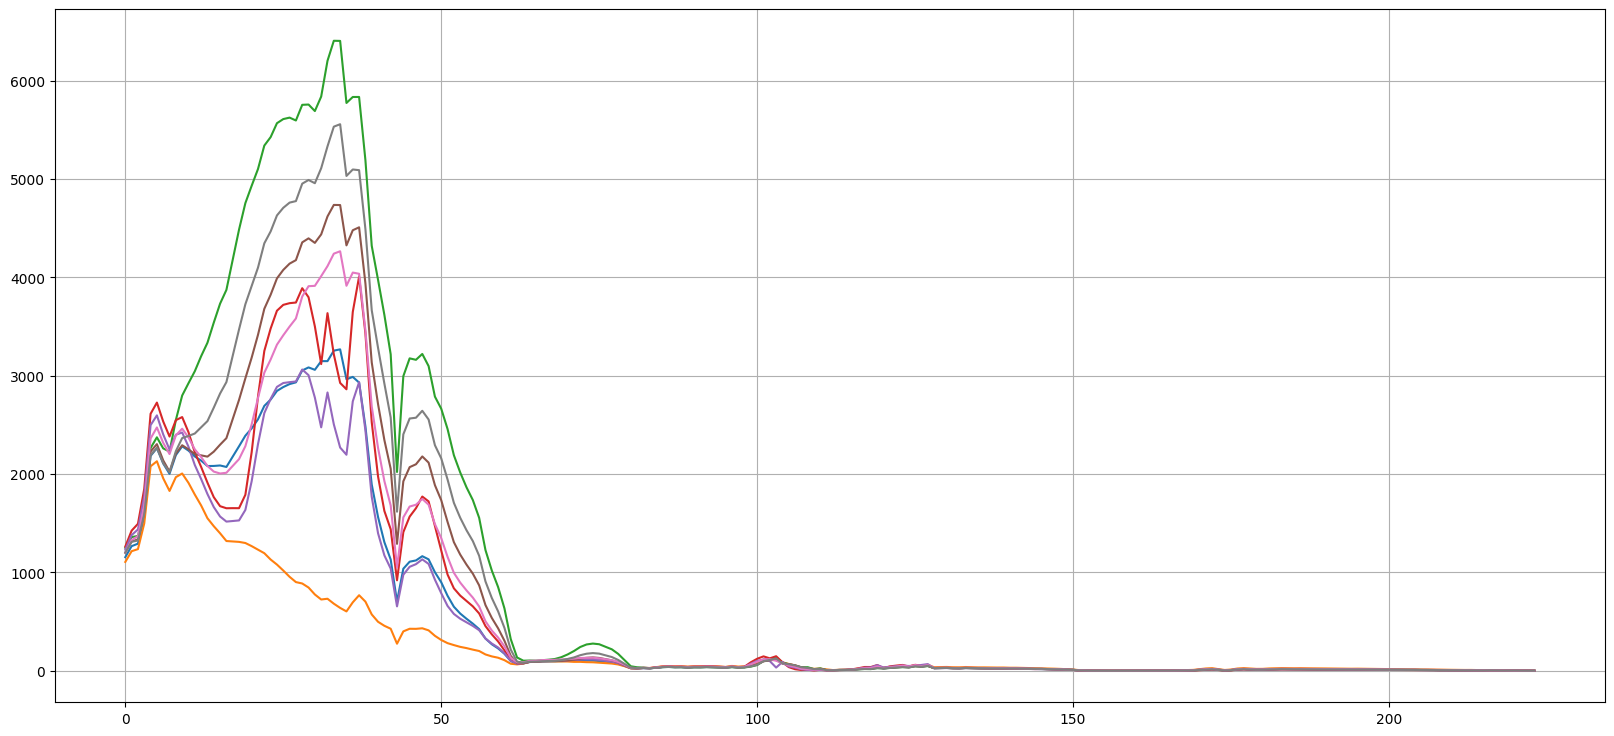

In [22]:
plt.figure(figsize = (20, 9))
for i in range(centers.shape[0]): #(0, 5):#
    plt.plot(centers[i])
plt.grid()
plt.show()

# combinations

In [246]:
pix_combinations = combinations(range(n_start_low_pix), n_clust)
pix_combinations = np.array(list(pix_combinations), dtype = int)

In [250]:
def evklid_dist(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [251]:
pix_combinations

array([[ 0,  1,  2, ...,  5,  6,  7],
       [ 0,  1,  2, ...,  5,  6,  8],
       [ 0,  1,  2, ...,  5,  6,  9],
       ...,
       [15, 16, 18, ..., 21, 22, 23],
       [15, 17, 18, ..., 21, 22, 23],
       [16, 17, 18, ..., 21, 22, 23]])

In [267]:
sum_dist = np.zeros(shape = (pix_combinations.shape[0], 8), dtype = float)

print(pix_combinations.shape[0])
for i in range(pix_combinations.shape[0]):
    
    for j in range(n_clust):
    
        h = low_corr_pix_arg[pix_combinations[i, j]][0]
        w = low_corr_pix_arg[pix_combinations[i, j]][1]
    
        sum_dist[i, j] = np.linalg.norm(main_diag_pix - norm_hsi[h, w])
    
    if i % 1000 == 0:
        print('\r', end = '')
        print(i, end = '')

735471
735400

In [277]:
np.mean(sum_dist, axis = 1)

array([1.05084501, 1.05084501, 1.05071011, ..., 1.04651998, 1.04648871,
       1.04648664])

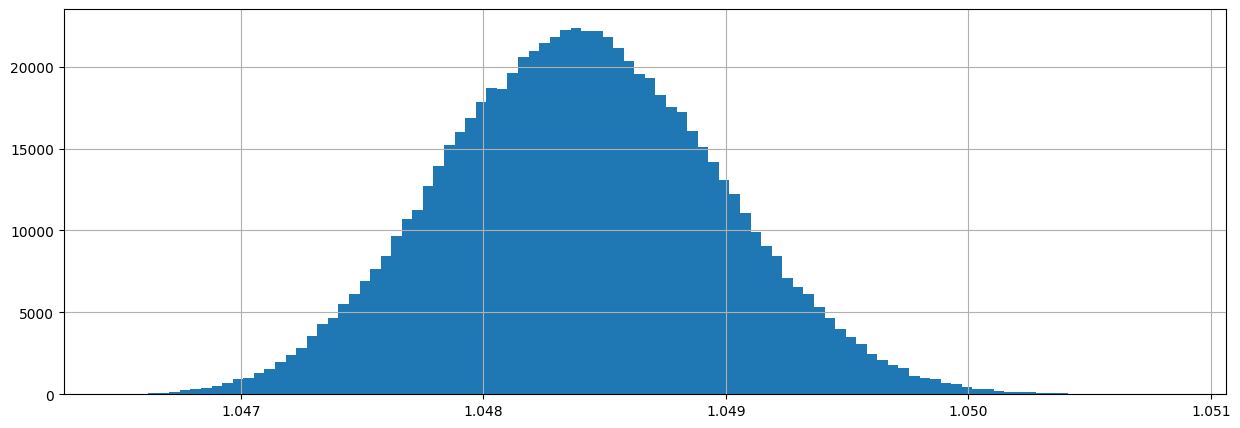

In [274]:
plt.figure(figsize = (15, 5))
plt.hist(np.mean(sum_dist, axis = 1), bins = 100)
plt.axis()
plt.grid()